In [57]:
!pip install wordcloud
# add a new dataset with equal split for offensive and non offensive
# try using SVMs 

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#library that contains punctuation
import string
string.punctuation

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# import spacy
# en = spacy.load('en_core_web_lg')
# stopwords = en.Defaults.stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sheetalsudhir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
path_to_data = "/Users/sheetalsudhir/Documents/SDP_ML/labeled_data2.csv"
labeled_df = pd.read_csv(path_to_data)

In [14]:
# assigns hate speech and offensive language to the same class
def create_new_class_col(x):
    if x == 1 or x == 0:
        return 1
    else:
        return 0

labeled_df['new_class'] = labeled_df['class'].apply(create_new_class_col)

In [15]:
labeled_df[:24818][['tweet', 'new_class']]

tweet  new_class
0      !!! RT @mayasolovely: As a woman you shouldn't...          0
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...          1
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          1
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...          1
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          1
...                                                  ...        ...
24813  Make a determination that you will live your p...          0
24814  The world is full of magical things patiently ...          0
24815  Words can inspire, thoughts can provoke, but o...          0
24816  May your troubles be less and your blessings b...          0
24817  Some men see things as they are and say why—I ...          0

[24818 rows x 2 columns]

## Text Preprocessing


In [16]:
# text_preprocessing, removes stopwords
stop_words = stopwords.words('english')
labeled_df['tweet'] = labeled_df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

# remove unnecessary punctuation
def remove_punctuation(text):
    if type(text)==float:
        return text
    new_text = ""  
    for i in text:
        if i not in string.punctuation:
            new_text+=i    
    return new_text

labeled_df['tweet'] = labeled_df['tweet'].apply(lambda x: remove_punctuation(x))

In [17]:
labeled_df

Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0             0.0    3.0          0.0                 0.0      3.0      2   
1             1.0    3.0          0.0                 3.0      0.0      1   
2             2.0    3.0          0.0                 3.0      0.0      1   
3             3.0    3.0          0.0                 2.0      1.0      1   
4             4.0    6.0          0.0                 6.0      0.0      1   
...           ...    ...          ...                 ...      ...    ...   
24823         NaN    NaN          NaN                 NaN      NaN      2   
24824         NaN    NaN          NaN                 NaN      NaN      2   
24825         NaN    NaN          NaN                 NaN      NaN      2   
24826         NaN    NaN          NaN                 NaN      NaN      2   
24827         NaN    NaN          NaN                 NaN      NaN      2   

                                                   tweet  new_class  
0       RT mayasolovely woman complain cleaning house...          0  
1       RT mleew17 boy dats coldtyga dwn bad cuffin d...          1  
2       RT UrKindOfBrand Dawg RT 80sbaby4life ever fu...          1  
3               RT CGAnderson vivabased look like tranny          1  
4       RT ShenikaRoberts shit hear might true might ...          1  
...                                                  ...        ...  
24823                             Computer science rocks          0  
24824                                   like sweets much          0  
24825                                  nothing say today          0  
24826                               Uconn amazing school          0  
24827                          Basketball favorite sport          0  

[24828 rows x 8 columns]

### N-Grams Model Visualization

In [18]:
n_grams_df = labeled_df[['tweet', 'new_class']].copy()

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

n_grams_df['one-grams'] = n_grams_df['tweet'].apply(lambda x: generate_ngrams(x))
n_grams_df['bigrams'] = n_grams_df['tweet'].apply(lambda x: generate_ngrams(x, 2))
n_grams_df['trigrams'] = n_grams_df['tweet'].apply(lambda x: generate_ngrams(x, 3))


In [19]:
from collections import defaultdict
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py


train1_df = labeled_df[labeled_df["new_class"]==1]
train0_df = labeled_df[labeled_df["new_class"]==0]

## custom function for ngram generation ##
## can n-grams be used for feature generation 
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# bar chart of non-offensive posts 
freq_dict = defaultdict(int)
for sent in train0_df["tweet"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# bar chart of offensive posts 
freq_dict = defaultdict(int)
for sent in train1_df["tweet"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non-offensive posts", 
                                          "Frequent words of offensive posts"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

/Users/sheetalsudhir/opt/anaconda3/lib/python3.9/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [20]:
# bar chart of non-offensive posts 
freq_dict = defaultdict(int)
for sent in train0_df["tweet"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# bar chart of offensive posts 
freq_dict = defaultdict(int)
for sent in train1_df["tweet"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non-offensive posts", 
                                          "Frequent words of offensive posts"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

/Users/sheetalsudhir/opt/anaconda3/lib/python3.9/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [21]:
# bar chart of non-offensive posts 
freq_dict = defaultdict(int)
for sent in train0_df["tweet"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# bar chart of offensive posts 
freq_dict = defaultdict(int)
for sent in train1_df["tweet"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non-offensive posts", 
                                          "Frequent words of offensive posts"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

/Users/sheetalsudhir/opt/anaconda3/lib/python3.9/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Generate Word Visualizations

In [22]:
# separate dataset based on the label column
offensive_df = labeled_df[labeled_df['new_class']==1]
non_offensive_df = labeled_df[labeled_df['new_class']==0]

def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

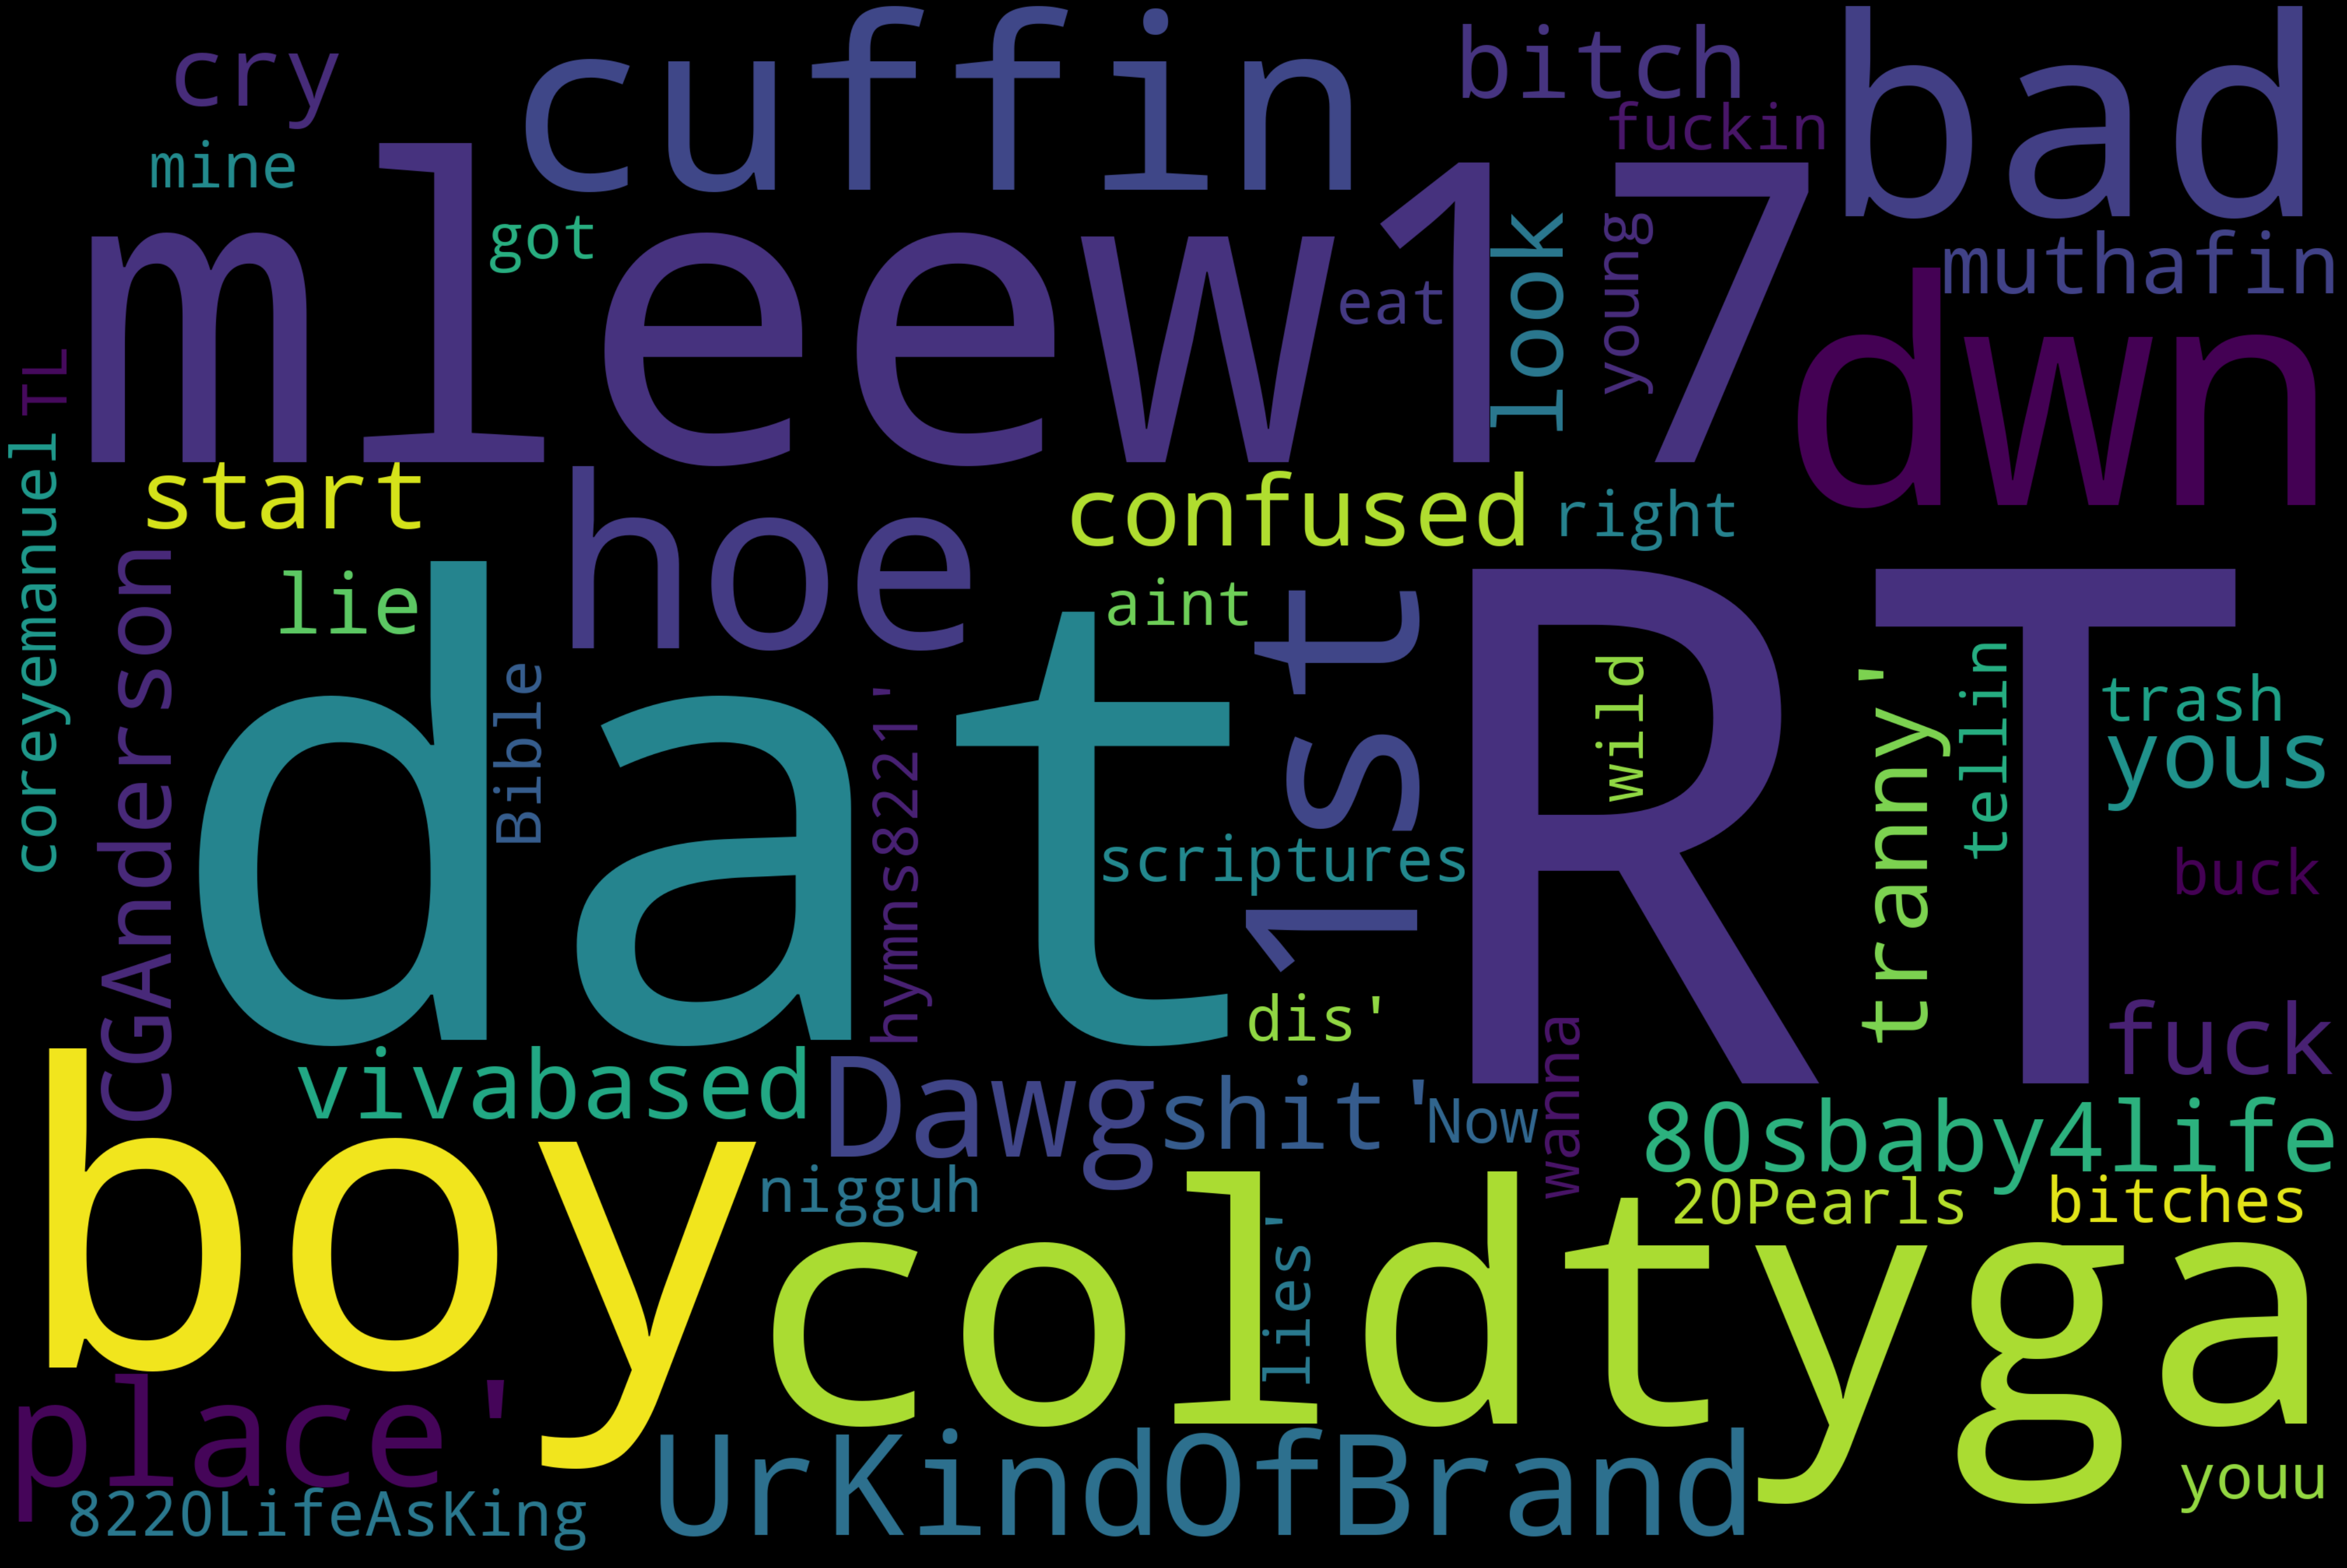

In [23]:
offensive_tweets = offensive_df.tweet.values
generate_word_cloud(offensive_tweets)

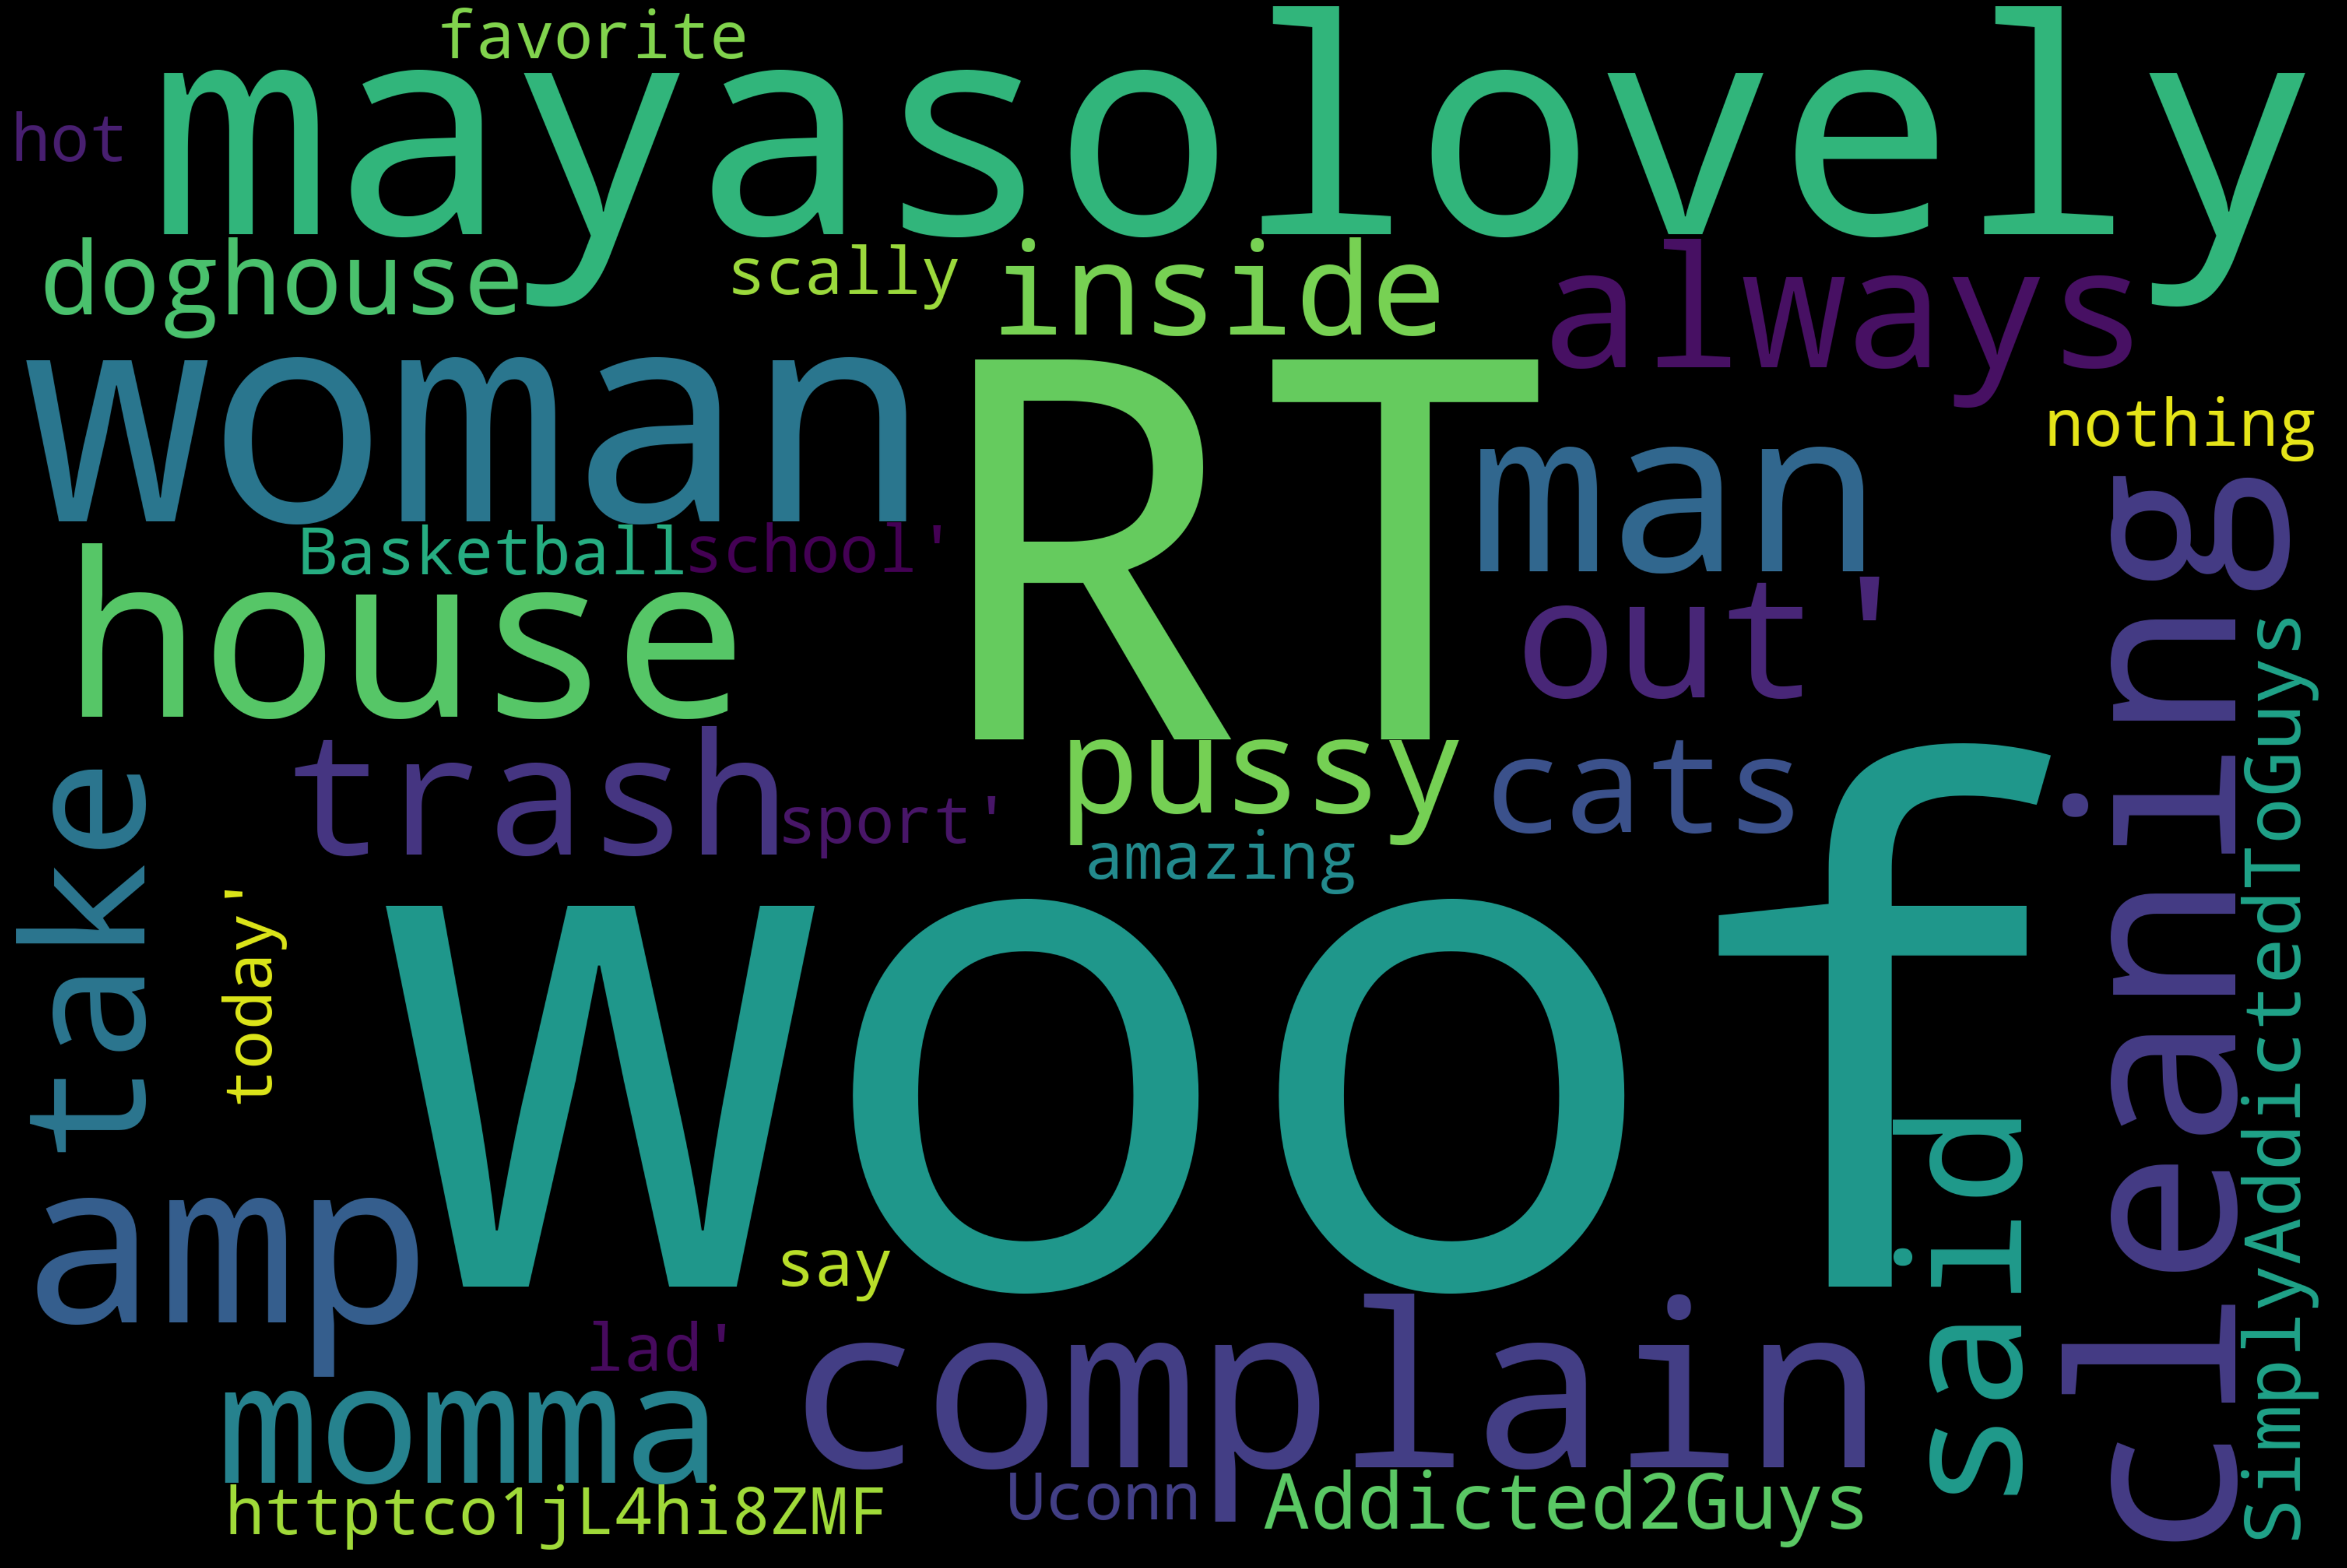

In [24]:
non_offensive_tweets = non_offensive_df.tweet.values
generate_word_cloud(non_offensive_tweets)

# Feature Extraction

### Tfidf Vectorizer

In [25]:
from sklearn.model_selection import train_test_split

X = labeled_df['tweet']
y = labeled_df['new_class']

X_train, X_test , y_train, y_test = train_test_split(labeled_df['tweet'].values,labeled_df['new_class'].values,
                                                     test_size=0.2,random_state=123,
                                                     stratify=labeled_df['new_class'].values)



In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer() 
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

### Multinomial Naive-Bayes

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report

clf = MultinomialNB()
clf.fit(tfidf_train_vectors,y_train)

MultinomialNB()

In [28]:
y_pred = clf.predict(tfidf_test_vectors)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.10      0.18       842
           1       0.84      1.00      0.92      4124

    accuracy                           0.85      4966
   macro avg       0.92      0.55      0.55      4966
weighted avg       0.87      0.85      0.79      4966



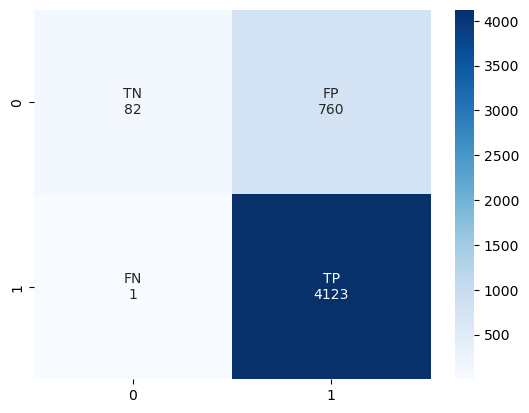

In [29]:
cnf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [30]:
sample = labeled_df.loc[0]['tweet']

#### SVM 

In [31]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
# Train the SVM on the training set
svm = LinearSVC()
svm.fit(tfidf_train_vectors, y_train)
# Obtain accuracy on the train set
y_hat = svm.predict(tfidf_train_vectors)
acc = accuracy_score(y_hat, y_train)
print(f"Accuracy on the train set: {acc:.4f}")

Accuracy on the train set: 0.9982


In [32]:
y_test_hat = svm.predict(tfidf_test_vectors)
acc = accuracy_score(y_test_hat, y_test)
print(f"Accuracy on the test set: {acc:.4f}")

Accuracy on the test set: 0.9487


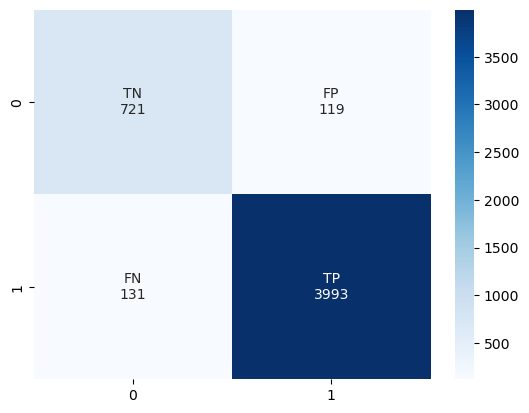

In [111]:
cnf_matrix = confusion_matrix(y_test,y_test_hat)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [33]:
from nltk.tokenize import word_tokenize

def remove_punctuation(text):
    if type(text)==float:
        return text
    new_text = ""
    for i in text:
        if i not in string.punctuation:
            new_text+=i
    return new_text

In [125]:
text_input = "i am angry today" ##this is the description its a string
stop_words = stopwords.words('english')
text_tokens = word_tokenize(text_input)
tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
new_text = (" ").join(tokens_without_sw)
new_text = remove_punctuation(new_text)
new_text_lst = [new_text]
tfidf_vector = tfidf_vectorizer.transform(new_text_lst)
prediction = svm.predict(tfidf_vector)
       
print(prediction)

[0]


In [124]:
text_input = "i am angry today" ##this is the description its a string
stop_words = stopwords.words('english')
text_tokens = word_tokenize(text_input)
tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
new_text = (" ").join(tokens_without_sw)
new_text = remove_punctuation(new_text)
new_text_lst = [new_text]
tfidf_vector = tfidf_vectorizer.transform(new_text_lst)
prediction = clf.predict(tfidf_vector)
       
print(prediction)

[1]


In [115]:
X_train.shape[0]

19855

In [116]:
X_test.shape[0]

4964

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


X = labeled_df['tweet']
y = labeled_df['new_class']

X_train, X_test , y_train, y_test = train_test_split(labeled_df['tweet'].values,labeled_df['new_class'].values,
                                                     test_size=0.2,random_state=123,
                                                     stratify=labeled_df['new_class'].values)

tfidf_vectorizer = TfidfVectorizer() 
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

# Train the SVM on the training set
svm = LinearSVC(C=10)
svm.fit(tfidf_train_vectors, y_train)
# Obtain accuracy on the train set
y_hat = svm.predict(tfidf_train_vectors)
acc = accuracy_score(y_hat, y_train)
print(f"Accuracy on the train set: {acc:.4f}")
y_test_hat = svm.predict(tfidf_test_vectors)
acc = accuracy_score(y_test_hat, y_test)
print(f"Accuracy on the validation set: {acc:.4f}")

Accuracy on the train set: 0.9997
Accuracy on the validation set: 0.9414
